<a href="https://colab.research.google.com/github/c4bath/cf860/blob/main/APTOS_MobileNetV2_CLAHE_d3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File Details

Dataset: APTOS w CLAHE preprocessing

Model: MobileNetV2

Adapted from

Transfer learning and fine-tuning

https://www.tensorflow.org/tutorials/images/transfer_learning

coursera - Retinopathy Detection Using Deep Learning

 https://www.coursera.org/learn/retinopathy-detection-using-deep-learning/supplement/em4yb/project-based-course-overview



In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import seaborn as sns
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score, matthews_corrcoef
from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  3 16:09:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
os.listdir('/content/drive/MyDrive/train')

['Mild', 'Moderate', 'No_DR', 'Proliferative_DR', 'Severe']

In [6]:
# To have reproducible results
seed = 27

np.random.seed(seed)

tf.random.set_seed(seed)

num_classes = 5

IMG_SIZE = (224,224)

In [7]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('/content/drive/MyDrive/train'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))
print('Number of train labels : {} \n'.format(len(label)))

Number of train images : 3662 

Number of train labels : 3662 



In [8]:
No_images_per_class = []
Class_name = []
for i in os.listdir('/content/drive/MyDrive/train'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Proliferative_DR = 295 

Number of images in Severe = 193 



In [9]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df

,Image,Labels
0,train/Mild/677f087cd697.png,Mild
1,train/Mild/ea15a290eb96.png,Mild
2,train/Mild/07929d32b5b3.png,Mild
3,train/Mild/35d6c4c50072.png,Mild
4,train/Mild/a5a2a7003d60.png,Mild
...,...,...
3657,train/Severe/bb7e0a2544cd.png,Severe
3658,train/Severe/38055d8b9f08.png,Severe
3659,train/Severe/36b5b3c9fb32.png,Severe
3660,train/Severe/51269b77d312.png,Severe


In [10]:
# Shuffle the data and split it into training, testing and validation
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.3)
val, test = train_test_split(test, test_size = 0.5)

In [11]:
train_datagen =  ImageDataGenerator(
    zoom_range=0.15,  # set range for random zoom, changed from 0.15 to 0.3, now changed from 0.3 to 0.45, from 0.45 to 0.6
    fill_mode='constant',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,# randomly flip images
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255)


# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
base_path = '/content/drive/My Drive/'  # Your base path

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

validation_generator = val_datagen.flow_from_dataframe(
    val,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)


Found 2563 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [13]:
images, labels = next(test_generator)

In [14]:
example_image = images[0]


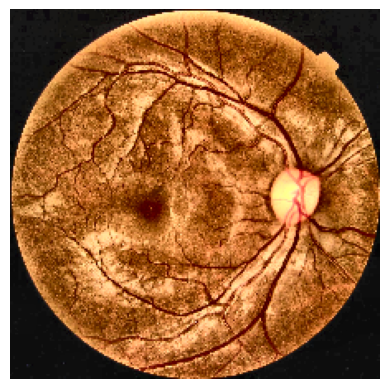

In [15]:
plt.imshow(example_image)
plt.axis('off')  # To turn off the axis
plt.show()

In [16]:
# Matthews Correlation Coefficient for multiple classes

class MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="matthews_correlation_coefficient", **kwargs):
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.confusion_matrix = self.add_weight(
            name="confusion_matrix",
            shape=(num_classes, num_classes),
            initializer="zeros"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)

        new_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, self.num_classes)
        new_confusion_matrix = tf.cast(new_confusion_matrix, self.confusion_matrix.dtype)

        return self.confusion_matrix.assign_add(new_confusion_matrix)

    def result(self):
        sum_over_row = tf.reduce_sum(self.confusion_matrix, axis=0)
        sum_over_col = tf.reduce_sum(self.confusion_matrix, axis=1)
        true_positives = tf.linalg.diag_part(self.confusion_matrix)
        predicted_positives = sum_over_row
        actual_positives = sum_over_col
        total_samples = tf.reduce_sum(sum_over_row)

        mcc_numerator = tf.reduce_sum(true_positives * total_samples - predicted_positives * actual_positives)
        mcc_denominator = tf.sqrt(
            (total_samples**2 - tf.reduce_sum(predicted_positives**2)) *
            (total_samples**2 - tf.reduce_sum(actual_positives**2))
        )

        mcc = mcc_numerator / mcc_denominator
        mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
        return mcc

    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros_like(s))

    def get_config(self):
        config = super(MatthewsCorrelationCoefficient, self).get_config()
        config.update({"num_classes": self.num_classes})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

mcc_metric = MatthewsCorrelationCoefficient(num_classes)

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [18]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [19]:
base_model.trainable = False

In [20]:
# Display Model
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs) already augmented in train_generator
#x = preprocess_input(x) already rescaled in train and val_generator
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02

In [25]:
len(model.trainable_variables)

2

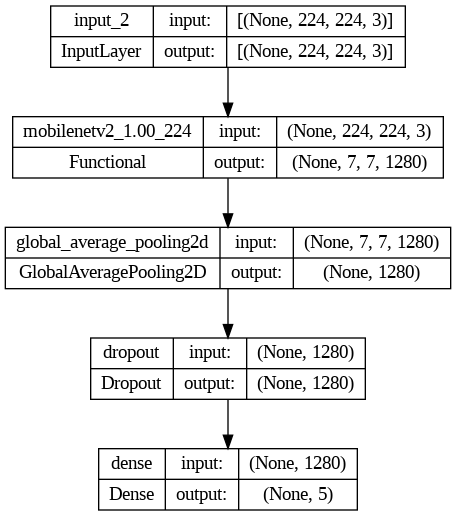

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalCrossentropy(name='accuracy'),mcc_metric])

In [28]:
#apply early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lowest validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/drweights/MobileNetV2D3a.hdf5", verbose=1, save_best_only=True)


In [29]:
initial_epochs = 10

In [30]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = initial_epochs, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 1.5378 - accuracy: 1.5378 - matthews_correlation_coefficient: 0.0645 
Epoch 1: val_loss improved from inf to 1.30511, saving model to /content/drive/MyDrive/drweights/MobileNetV2D3a.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



80/80 [==============================] - 1363s 17s/step - loss: 1.5378 - accuracy: 1.5378 - matthews_correlation_coefficient: 0.0645 - val_loss: 1.3051 - val_accuracy: 1.3051 - val_matthews_correlation_coefficient: 0.2021
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 1.2588 - accuracy: 1.2588 - matthews_correlation_coefficient: 0.2573
Epoch 2: val_loss improved from 1.30511 to 1.16495, saving model to /content/drive/MyDrive/drweights/MobileNetV2D3a.hdf5
80/80 [==============================] - 42s 527ms/step - loss: 1.2588 - accuracy: 1.2588 - matthews_correlation_coefficient: 0.2573 - val_loss: 1.1649 - val_accuracy: 1.1649 - val_matthews_correlation_coefficient: 0.3072
Epoch 3/10
80/80 [==============================] - ETA: 0s - loss: 1.1298 - accuracy: 1.1298 - matthews_correlation_coefficient: 0.3491
Epoch 3: val_loss improved from 1.16495 to 1.08111, saving model to /content/drive/MyDrive/drweights/MobileNetV2D3a.hdf5
80/80 [==============================] -

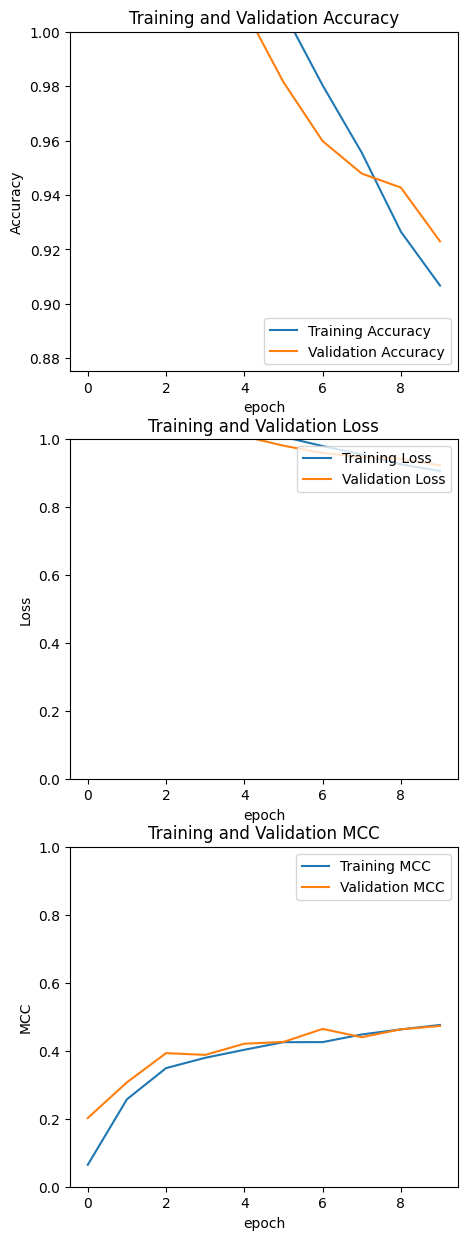

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

matthews_correlation_coefficient = history.history['matthews_correlation_coefficient']
val_matthews_correlation_coefficient = history.history['val_matthews_correlation_coefficient']

fig, axs = plt.subplots(3, 1, figsize=(5, 15))

plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')


plt.subplot(3, 1, 3)
plt.plot(matthews_correlation_coefficient, label='Training MCC')
plt.plot(val_matthews_correlation_coefficient, label='Validation MCC')
plt.legend(loc='upper right')
plt.ylabel('MCC')
plt.ylim([0,1.0])
plt.title('Training and Validation MCC')
plt.xlabel('epoch')
plt.show()

In [32]:
# Loss
min_loss_index = np.argmin(history.history['loss'])
min_loss_value = round(history.history['loss'][min_loss_index], 4)
print(f'The epoch with the lowest loss is: {min_loss_index + 1} (Loss: {min_loss_value})')

# Validation Loss
min_val_loss_index = np.argmin(history.history['val_loss'])
min_val_loss_value = round(history.history['val_loss'][min_val_loss_index], 4)
print(f'The epoch with the lowest val_loss is: {min_val_loss_index + 1} (Val Loss: {min_val_loss_value})')

# Accuracy
max_accuracy_index = np.argmax(history.history['accuracy'])
max_accuracy_value = round(history.history['accuracy'][max_accuracy_index], 4)
print(f'The epoch with the highest accuracy is: {max_accuracy_index + 1} (Accuracy: {max_accuracy_value})')

# Validation Accuracy
max_val_acc_index = np.argmax(history.history['val_accuracy'])
max_val_acc_value = round(history.history['val_accuracy'][max_val_acc_index], 4)
print(f'The epoch with the highest validation accuracy is: {max_val_acc_index + 1} (Val Accuracy: {max_val_acc_value})')

# Matthews Correlation Coefficient (MCC)
max_mcc_index = np.argmax(history.history['matthews_correlation_coefficient'])
max_mcc_value = round(history.history['matthews_correlation_coefficient'][max_mcc_index], 4)
print(f'The epoch with the highest MCC is: {max_mcc_index + 1} (MCC: {max_mcc_value})')

# Validation MCC
max_val_mcc_index = np.argmax(history.history['val_matthews_correlation_coefficient'])
max_val_mcc_value = round(history.history['val_matthews_correlation_coefficient'][max_val_mcc_index], 4)
print(f'The epoch with the highest validation MCC is: {max_val_mcc_index + 1} (Val MCC: {max_val_mcc_value})')

best_epoch_model = max_val_mcc_index + 1

The epoch with the lowest loss is: 10 (Loss: 0.9067)
The epoch with the lowest val_loss is: 10 (Val Loss: 0.923)
The epoch with the highest accuracy is: 1 (Accuracy: 1.5378)
The epoch with the highest validation accuracy is: 1 (Val Accuracy: 1.3051)
The epoch with the highest MCC is: 10 (MCC: 0.4762)
The epoch with the highest validation MCC is: 10 (Val MCC: 0.4733)


In [33]:
base_model.trainable = True

In [34]:
# Total layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalCrossentropy(name='accuracy'),mcc_metric])

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 1867845 (7.

In [37]:
len(model.trainable_variables)

56

In [38]:
fine_tune_epochs = 45
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = total_epochs, initial_epoch=history.epoch[-1], validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 10/55
80/80 [==============================] - ETA: 0s - loss: 0.8685 - accuracy: 0.8685 - matthews_correlation_coefficient: 0.4897
Epoch 10: val_loss improved from 0.92296 to 0.81780, saving model to /content/drive/MyDrive/drweights/MobileNetV2D3a.hdf5
80/80 [==============================] - 58s 573ms/step - loss: 0.8685 - accuracy: 0.8685 - matthews_correlation_coefficient: 0.4897 - val_loss: 0.8178 - val_accuracy: 0.8178 - val_matthews_correlation_coefficient: 0.5370
Epoch 11/55
80/80 [==============================] - ETA: 0s - loss: 0.7782 - accuracy: 0.7782 - matthews_correlation_coefficient: 0.5405
Epoch 11: val_loss improved from 0.81780 to 0.76798, saving model to /content/drive/MyDrive/drweights/MobileNetV2D3a.hdf5
80/80 [==============================] - 43s 539ms/step - loss: 0.7782 - accuracy: 0.7782 - matthews_correlation_coefficient: 0.5405 - val_loss: 0.7680 - val_accuracy: 0.7680 - val_matthews_correlation_coefficient: 0.5748
Epoch 12/55
80/80 [=================

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

matthews_correlation_coefficient += history_fine.history['matthews_correlation_coefficient']
val_matthews_correlation_coefficient += history_fine.history['val_matthews_correlation_coefficient']

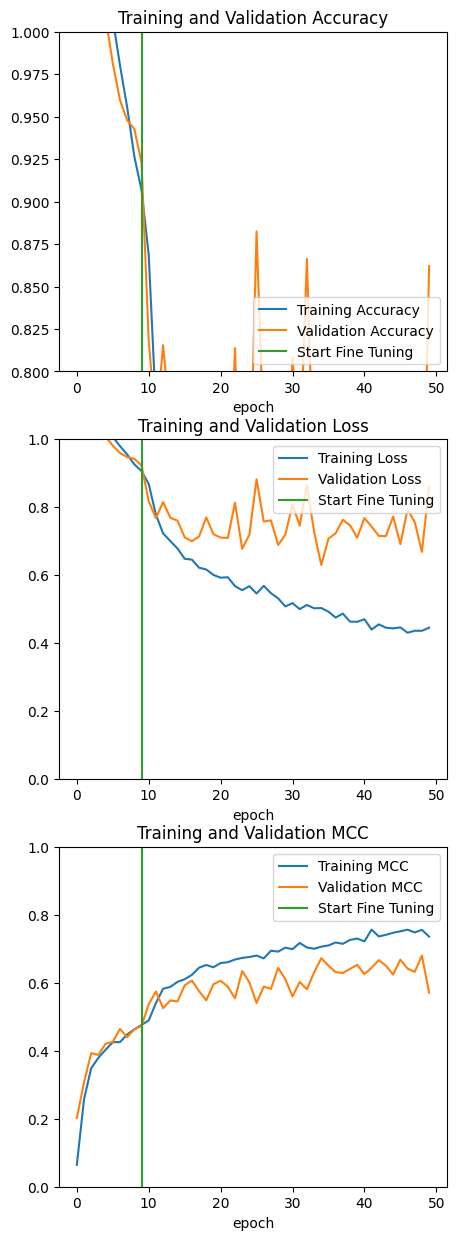

In [40]:
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(matthews_correlation_coefficient, label='Training MCC')
plt.plot(val_matthews_correlation_coefficient, label='Validation MCC')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation MCC')
plt.xlabel('epoch')

plt.show()

In [41]:
# Loss
min_loss_index = np.argmin(history_fine.history['loss'])
min_loss_value = round(history_fine.history['loss'][min_loss_index], 4)
print(f'The epoch with the lowest loss is: {min_loss_index + 1} (Loss: {min_loss_value})')

# Validation Loss
min_val_loss_index = np.argmin(history_fine.history['val_loss'])
min_val_loss_value = round(history_fine.history['val_loss'][min_val_loss_index], 4)
print(f'The epoch with the lowest val_loss is: {min_val_loss_index + 1} (Val Loss: {min_val_loss_value})')

# Accuracy
max_accuracy_index = np.argmax(history_fine.history['accuracy'])
max_accuracy_value = round(history_fine.history['accuracy'][max_accuracy_index], 4)
print(f'The epoch with the highest accuracy is: {max_accuracy_index + 1} (Accuracy: {max_accuracy_value})')

# Validation Accuracy
max_val_acc_index = np.argmax(history_fine.history['val_accuracy'])
max_val_acc_value = round(history_fine.history['val_accuracy'][max_val_acc_index], 4)
print(f'The epoch with the highest validation accuracy is: {max_val_acc_index + 1} (Val Accuracy: {max_val_acc_value})')

# Matthews Correlation Coefficient (MCC)
max_mcc_index = np.argmax(history_fine.history['matthews_correlation_coefficient'])
max_mcc_value = round(history_fine.history['matthews_correlation_coefficient'][max_mcc_index], 4)
print(f'The epoch with the highest MCC is: {max_mcc_index + 1} (MCC: {max_mcc_value})')

# Validation MCC
max_val_mcc_index = np.argmax(history_fine.history['val_matthews_correlation_coefficient'])
max_val_mcc_value = round(history_fine.history['val_matthews_correlation_coefficient'][max_val_mcc_index], 4)
print(f'The epoch with the highest validation MCC is: {max_val_mcc_index + 1} (Val MCC: {max_val_mcc_value})')

best_epoch_model = max_val_mcc_index + 1

The epoch with the lowest loss is: 37 (Loss: 0.4308)
The epoch with the lowest val_loss is: 25 (Val Loss: 0.6304)
The epoch with the highest accuracy is: 1 (Accuracy: 0.8685)
The epoch with the highest validation accuracy is: 16 (Val Accuracy: 0.8824)
The epoch with the highest MCC is: 32 (MCC: 0.757)
The epoch with the highest validation MCC is: 39 (Val MCC: 0.6806)


In [42]:
model.load_weights("/content/drive/MyDrive/drweights/MobileNetV2D3a.hdf5")


In [61]:
loss, accuracy, matthews_correlation_coefficient = model.evaluate(test_generator)
print('Test accuracy :', accuracy, 'Test MCC :', matthews_correlation_coefficient)

18/18 [==============================] - 3s 141ms/step - loss: 0.5901 - accuracy: 0.5901 - matthews_correlation_coefficient: 0.6793
Test accuracy : 0.5900775790214539 Test MCC : 0.6792711019515991


In [62]:

# Predict with the model on the test set
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Retrieve the true labels from the test generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys(),zero_division=0)
print("Classification Report:")
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

18/18 [==============================] - 4s 236ms/step
Classification Report:
                  precision    recall  f1-score   support

            Mild       0.07      0.05      0.06        55
        Moderate       0.28      0.34      0.30       164
           No_DR       0.46      0.50      0.48       259
Proliferative_DR       0.08      0.04      0.06        45
          Severe       0.00      0.00      0.00        27

        accuracy                           0.34       550
       macro avg       0.18      0.19      0.18       550
    weighted avg       0.31      0.34      0.33       550

Confusion Matrix:
[[  3  23  26   3   0]
 [  9  55  89   9   2]
 [ 23  96 129   8   3]
 [  6  13  24   2   0]
 [  2  10  13   2   0]]


In [63]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


# Calculate the metrics with conditions to handle division by zero
TPR = np.divide(TP, TP + FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
TNR = np.divide(TN, TN + FP, out=np.zeros_like(TN), where=(TN+FP)!=0)
PPV = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
NPV = np.divide(TN, TN + FN, out=np.zeros_like(TN), where=(TN+FN)!=0)
FPR = np.divide(FP, FP + TN, out=np.zeros_like(FP), where=(FP+TN)!=0)
FNR = np.divide(FN, TP + FN, out=np.zeros_like(FN), where=(TP+FN)!=0)
FDR = np.divide(FP, TP + FP, out=np.zeros_like(FP), where=(TP+FP)!=0)
ACC = np.divide(TP + TN, TP + FP + FN + TN, out=np.zeros_like(TP+TN), where=(TP+FP+FN+TN)!=0)

# Print metrics for each class
for i in range(len(class_names)):
    print(f"Class - {class_names[i]}")
    print(f"  Sensitivity: {TPR[i]}")
    print(f"  Specificity: {TNR[i]}")
    print(f"  Precision: {PPV[i]}")
    print(f"  Negative Predictive Value: {NPV[i]}")
    print(f"  False Positive Rate: {FPR[i]}")
    print(f"  False Negative Rate: {FNR[i]}")
    print(f"  False Discovery Rate: {FDR[i]}")
    print(f"  Overall Accuracy: {ACC[i]}\n")

Class - No DR
  Sensitivity: 0.05454545454545454
  Specificity: 0.9191919191919192
  Precision: 0.06976744186046512
  Negative Predictive Value: 0.8974358974358975
  False Positive Rate: 0.08080808080808081
  False Negative Rate: 0.9454545454545454
  False Discovery Rate: 0.9302325581395349
  Overall Accuracy: 0.8327272727272728

Class - Mild
  Sensitivity: 0.3353658536585366
  Specificity: 0.6321243523316062
  Precision: 0.27918781725888325
  Negative Predictive Value: 0.6912181303116147
  False Positive Rate: 0.36787564766839376
  False Negative Rate: 0.6646341463414634
  False Discovery Rate: 0.7208121827411168
  Overall Accuracy: 0.5436363636363636

Class - Moderate
  Sensitivity: 0.4980694980694981
  Specificity: 0.47766323024054985
  Precision: 0.45907473309608543
  Negative Predictive Value: 0.516728624535316
  False Positive Rate: 0.5223367697594502
  False Negative Rate: 0.5019305019305019
  False Discovery Rate: 0.5409252669039146
  Overall Accuracy: 0.48727272727272725

Clas

<ipython-input-64-86800b8bc2b8>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



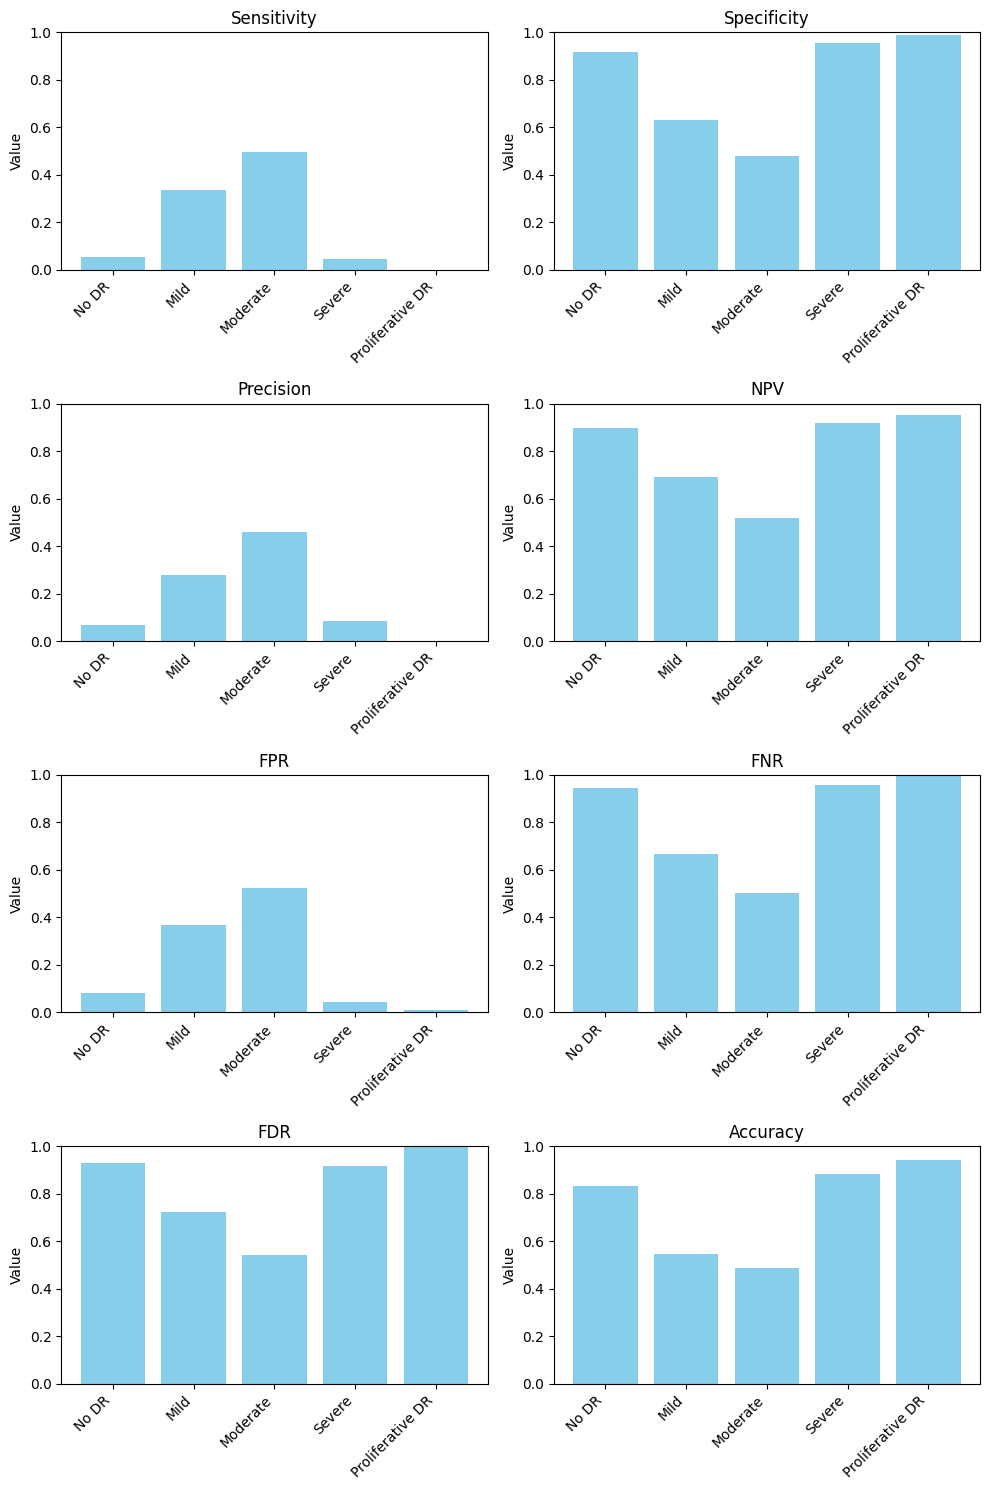

In [64]:
# Metrics to plot
metrics = [TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC]
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'NPV', 'FPR', 'FNR', 'FDR', 'Accuracy']

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i], color='skyblue')
    ax.set_title(metric_names[i])
    ax.set_ylim(0, 1)  # Assuming metrics are between 0 and 1
    ax.set_ylabel('Value')
    ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()

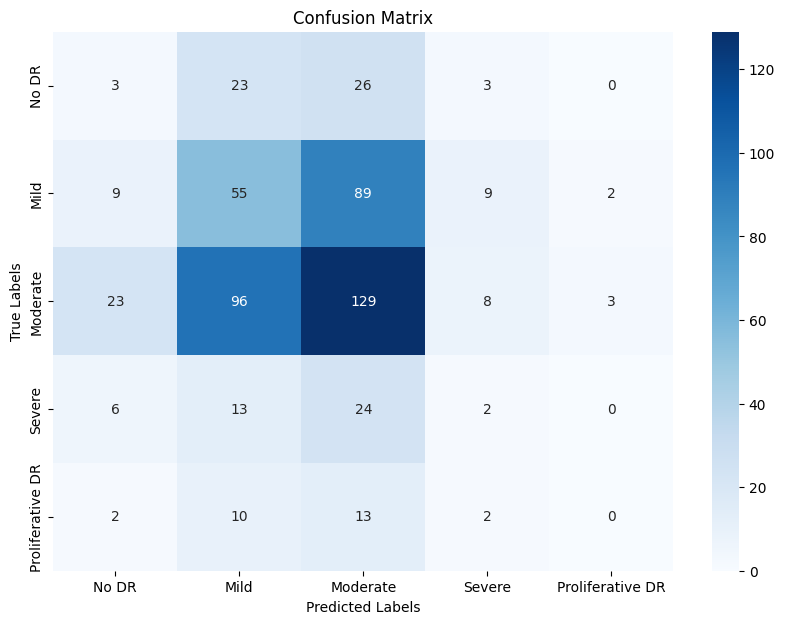

In [65]:
class_labels = class_names

plt.figure(figsize=(10, 7))

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Evaluate on Kaggle test dataset

In [47]:
'''
# Load kaggle test dataset
images_path = '/content/drive/MyDrive/minitestarrays/mtestimages.npy'
labels_path = '/content/drive/MyDrive/minitestarrays/mtestlabels.npy'

# Load the arrays
mtestimages = np.load(images_path)
mtestlabels = np.load(labels_path)
'''

"\n# Load kaggle test dataset\nimages_path = '/content/drive/MyDrive/minitestarrays/mtestimages.npy'\nlabels_path = '/content/drive/MyDrive/minitestarrays/mtestlabels.npy'\n\n# Load the arrays\nmtestimages = np.load(images_path)\nmtestlabels = np.load(labels_path)\n"

In [66]:
eyepacs_df = pd.read_csv('/content/drive/MyDrive/minitest.csv')
eyepacs_df.rename(columns={'image': 'Image', 'level': 'Labels'}, inplace=True)
eyepacs_df['Labels'].replace({0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative_DR'}, inplace=True)
eyepacs_df['Image'] = eyepacs_df['Image'] + '.jpeg'
eyepacs_df.head()

,Image,Labels
0,17123_right.jpeg,No_DR
1,12616_right.jpeg,No_DR
2,6541_left.jpeg,No_DR
3,14418_right.jpeg,No_DR
4,39598_left.jpeg,No_DR


In [67]:
# eyepacs generator

eyepacs_datagen = ImageDataGenerator(rescale = 1./255)

base_path = '/content/drive/My Drive/eyepacs'  # Your base path

eyepacs_generator = eyepacs_datagen.flow_from_dataframe(
    eyepacs_df,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 1001 validated image filenames belonging to 5 classes.


In [68]:
# Predict with the model on the test set
predictions = model.predict(eyepacs_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Retrieve the true labels from the test generator
true_labels = eyepacs_generator.classes

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=eyepacs_generator.class_indices.keys(),zero_division=0)
print("Classification Report:")
print(report)

# Generate the confusion matrix
epconf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(epconf_matrix)

32/32 [==============================] - 3s 96ms/step
Classification Report:
                  precision    recall  f1-score   support

            Mild       0.00      0.00      0.00        70
        Moderate       0.19      0.03      0.06       151
           No_DR       0.73      0.96      0.83       735
Proliferative_DR       0.00      0.00      0.00        20
          Severe       0.00      0.00      0.00        25

        accuracy                           0.71      1001
       macro avg       0.19      0.20      0.18      1001
    weighted avg       0.57      0.71      0.62      1001

Confusion Matrix:
[[  0   0  68   2   0]
 [  0   5 144   2   0]
 [  1  21 705   7   1]
 [  0   0  20   0   0]
 [  0   0  24   1   0]]


In [69]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

FP = epconf_matrix.sum(axis=0) - np.diag(epconf_matrix)
FN = epconf_matrix.sum(axis=1) - np.diag(epconf_matrix)
TP = np.diag(epconf_matrix)
TN = epconf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


# Calculate the metrics with conditions to handle division by zero
TPR = np.divide(TP, TP + FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
TNR = np.divide(TN, TN + FP, out=np.zeros_like(TN), where=(TN+FP)!=0)
PPV = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
NPV = np.divide(TN, TN + FN, out=np.zeros_like(TN), where=(TN+FN)!=0)
FPR = np.divide(FP, FP + TN, out=np.zeros_like(FP), where=(FP+TN)!=0)
FNR = np.divide(FN, TP + FN, out=np.zeros_like(FN), where=(TP+FN)!=0)
FDR = np.divide(FP, TP + FP, out=np.zeros_like(FP), where=(TP+FP)!=0)
ACC = np.divide(TP + TN, TP + FP + FN + TN, out=np.zeros_like(TP+TN), where=(TP+FP+FN+TN)!=0)

# Print metrics for each class
for i in range(len(class_names)):
    print(f"Class - {class_names[i]}")
    print(f"  Sensitivity: {TPR[i]}")
    print(f"  Specificity: {TNR[i]}")
    print(f"  Precision: {PPV[i]}")
    print(f"  Negative Predictive Value: {NPV[i]}")
    print(f"  False Positive Rate: {FPR[i]}")
    print(f"  False Negative Rate: {FNR[i]}")
    print(f"  False Discovery Rate: {FDR[i]}")
    print(f"  Overall Accuracy: {ACC[i]}\n")



Class - No DR
  Sensitivity: 0.0
  Specificity: 0.9989258861439313
  Precision: 0.0
  Negative Predictive Value: 0.93
  False Positive Rate: 0.0010741138560687433
  False Negative Rate: 1.0
  False Discovery Rate: 1.0
  Overall Accuracy: 0.929070929070929

Class - Mild
  Sensitivity: 0.033112582781456956
  Specificity: 0.9752941176470589
  Precision: 0.19230769230769232
  Negative Predictive Value: 0.8502564102564103
  False Positive Rate: 0.024705882352941175
  False Negative Rate: 0.9668874172185431
  False Discovery Rate: 0.8076923076923077
  Overall Accuracy: 0.8331668331668332

Class - Moderate
  Sensitivity: 0.9591836734693877
  Specificity: 0.03759398496240601
  Precision: 0.7336108220603538
  Negative Predictive Value: 0.25
  False Positive Rate: 0.9624060150375939
  False Negative Rate: 0.04081632653061224
  False Discovery Rate: 0.2663891779396462
  Overall Accuracy: 0.7142857142857143

Class - Severe
  Sensitivity: 0.0
  Specificity: 0.9877675840978594
  Precision: 0.0
  Neg

<ipython-input-70-86800b8bc2b8>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



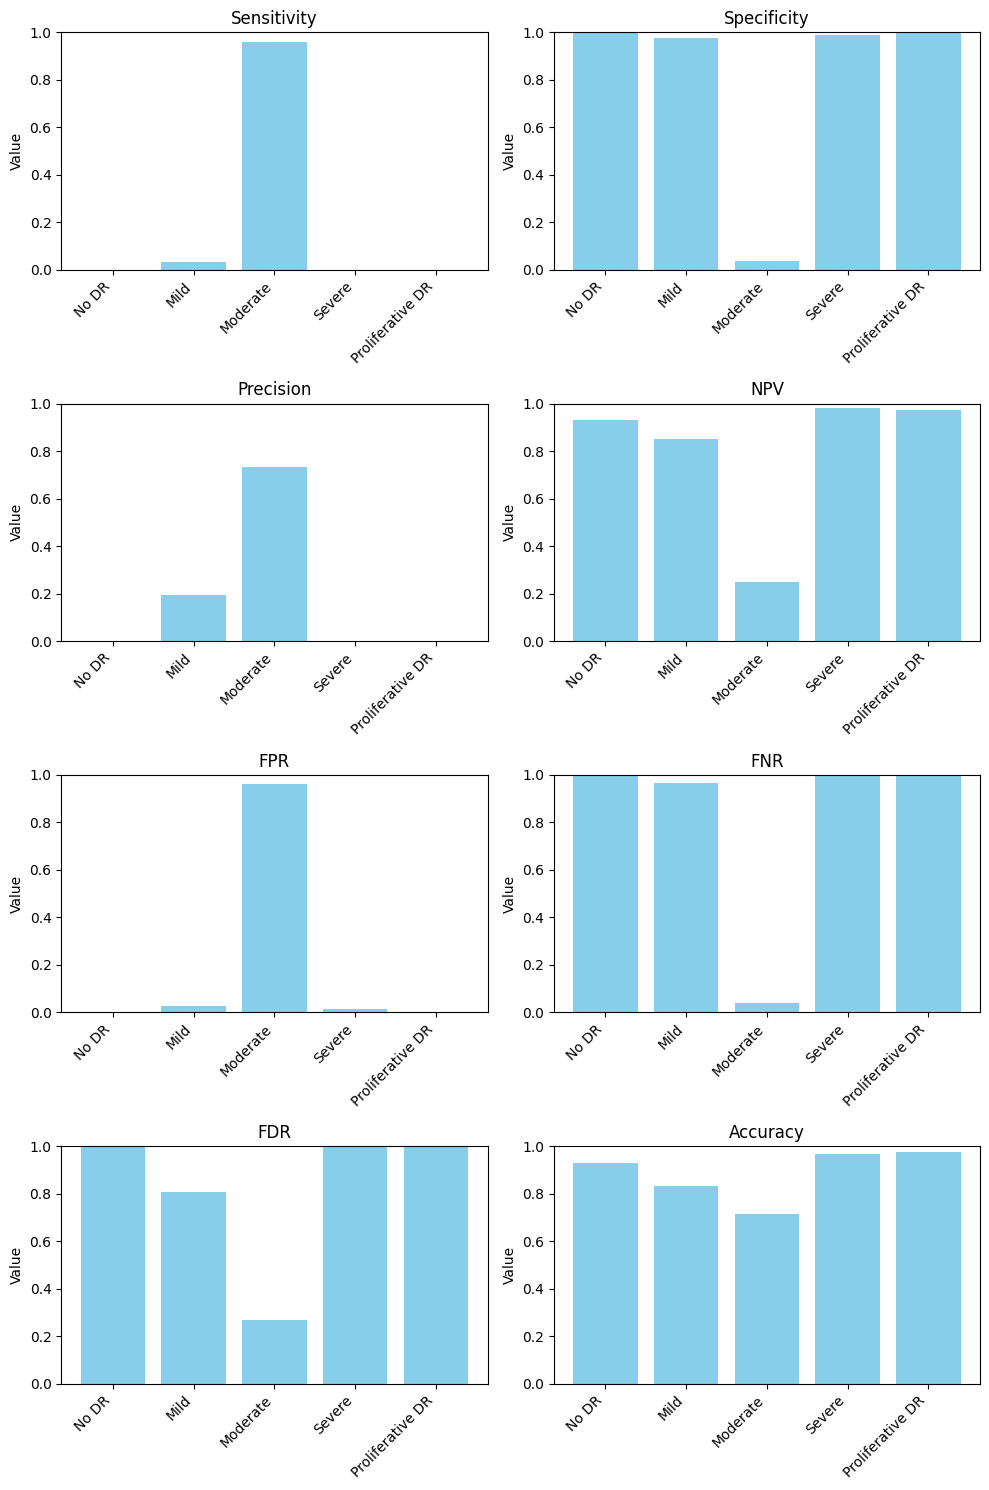

In [70]:
# Metrics to plot
metrics = [TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC]
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'NPV', 'FPR', 'FNR', 'FDR', 'Accuracy']

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i], color='skyblue')
    ax.set_title(metric_names[i])
    ax.set_ylim(0, 1)  # Assuming metrics are between 0 and 1
    ax.set_ylabel('Value')
    ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()


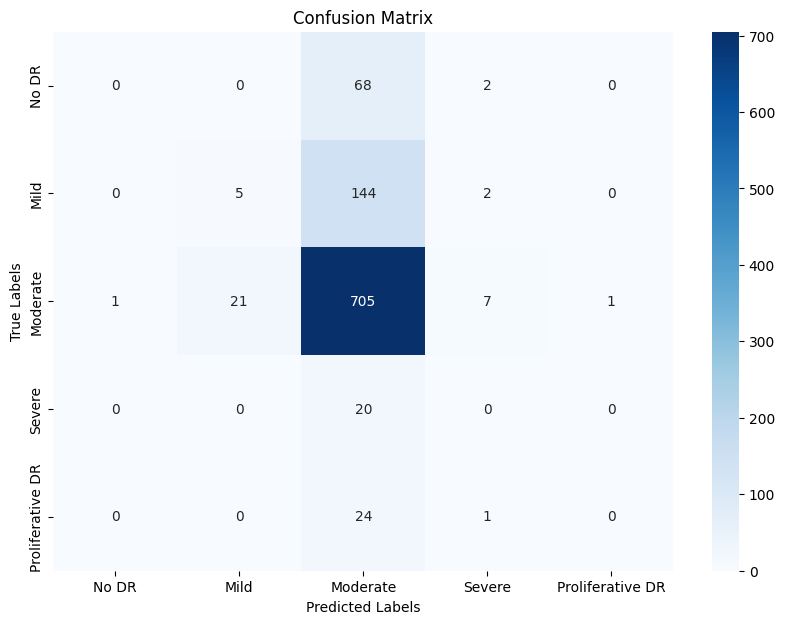

In [71]:
class_labels = class_names

plt.figure(figsize=(10, 7))

# Create a heatmap
sns.heatmap(epconf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()